<big><big><big><b> Cathumbnailer </big></big></big></b>

Notebook which:
<ul>
    <li> downloads cat photos from the internet </li>
    <li> creates thumbnails of these photos (size can be set by yourself) </li>
    <li> compares runtime of software and hardware thumbnailer using the resizer overlay from the PYNQ Hello-World example
</ul>
 
 



<big><b> Import libraries </big></b>

In [1]:
### Lib for downloading images
from simple_image_download import simple_image_download as simp
from IPython.display import Image

### Lib for os-path interaction
import os
from pathlib import Path

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pynq import allocate, Overlay

<big><b> Download cat images </big></b>

In [2]:
### TODO download cat images into the folder `simple_images/cat/`
response = simp.simple_image_download
searchterm = 'cat'

response().download(searchterm, 15)

Varibale <b>Thumbnail_Width</b> sets the width of the generated thumbnail

In [3]:
Thumbail_Width = 64

<big><b> CPU Resizer Function </big></b>

In [4]:
def cpu_resize_images(image_path, img_num):
    
    ### Create an Image object
    original_image = Image.open(image_path)
    
    ### Resizing
    old_width, old_height = original_image.size
    ## print("old image size: {}x{} pixels.".format(old_width, old_height))
    
    new_width = Thumbail_Width
    resize_factor = int(old_width/new_width + 0.5)
    new_height = int(old_height/resize_factor + 0.5)
    
    resized_image = original_image.resize((new_width, new_height), Image.BILINEAR)
    
    res_width, res_height = resized_image.size
    ## print("new image size: {}x{} pixels.".format(res_width, res_height))
    
    ### Save Image
    resized_image.save(r"result_images/Software/resized_cat_"+str(img_num)+".jpg")

    return resized_image

<big><b> Hardware Resizer Function </big></b>

In [5]:
def fpga_resize_images(image_path, img_num):
    
    ## Save result image to the following directory!
    res_directory = 'result_images'
    
    resize_design = Overlay("resizer.bit")
    dma = resize_design.axi_dma_0
    resizer = resize_design.resize_accel_0
    
    ### Create an Image object
    original_image = Image.open(image_path)
    
    ### Resizing
    old_width, old_height = original_image.size
    ## print("Image size: {}x{} pixels.".format(old_width, old_height))
    
    if(old_width > 4000 or old_height > 4000):
        ## print("Picture to large for the image resizer,... yes, really")
        return()
    
    new_width = Thumbail_Width
    resize_factor = int(old_width/new_width + 0.5)
    new_height = int(old_height/resize_factor + 0.5)
    
    ###Create Hardware Buffer
    in_buffer = allocate(shape=(old_height, old_width, 3), dtype=np.uint8, cacheable=1)
    out_buffer = allocate(shape=(new_height, new_width, 3), dtype=np.uint8, cacheable=1)
    
    in_buffer[:] = np.array(original_image)
        
    ### Write dimension data to MMIO register
    resizer.write(0x10, old_height)
    resizer.write(0x18, old_width)
    resizer.write(0x20, new_height)
    resizer.write(0x28, new_width)
    
    ### Run Kernel
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    resizer.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    
    ### Readout resized image
    resized_image = Image.fromarray(out_buffer)
    
    res_width, res_height = resized_image.size
    ## print("Image size: {}x{} pixels.".format(res_width, res_height))
    
    ### Save Image
    resized_image.save(r"result_images/Hardware/resized_cat_"+str(img_num)+".jpg")
    
    # Reset Memory buffer
    del in_buffer
    del out_buffer
    
    return resized_image

Call CPU Resizer Function in for loop for every picture.
Check if the picture can be opened before the CPU Resizer Function is executed.

In [6]:
def software():
    directory = 'simple_images/cat'
    img_num = 1

    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            try:
                original_image = Image.open(os.path.join(directory, filename))
            except OSError:
                a=5 #sonst Fehlermeldung
            else:
                cpu_resize_images(os.path.join(directory, filename), img_num)
                img_num += 1;
        else:
            continue


Call Hardware Resizer Function in for loop for every picture.
Check if the picture can be opened before the Hardware Resizer Function is executed.

In [7]:
def hardware():
    directory = 'simple_images/cat'
    img_num = 1

    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            try:
                original_image = Image.open(os.path.join(directory, filename))
            except OSError:
                a=5 #sonst Fehlermeldung
            else:
                fpga_resize_images(os.path.join(directory, filename), img_num)
                img_num += 1;
        else:
            continue


<big><b> Comparision of the runtime of software and hardware thumbnailer </big></b>

Call the Resizer function with three different values for the variable Thumnail_Width: 64, 128, 256

Determination of the execution time of the CPU Resizer Function 

In [8]:
# TODO timeit cpu_resize_images(image_paths)
soft_time = []

for x in [64, 256, 512]:
    Thumbail_Width = x

    a = %timeit -n 1 -r 1 -o software()
    soft_time.append(a.best)

1 loop, best of 1: 9.58 s per loop
1 loop, best of 1: 9.79 s per loop
1 loop, best of 1: 10.9 s per loop


Determination of the execution time of the Hardware Resizer Function 

In [9]:
# TODO timeit fpga_resize_images(image_paths)
hard_time = []

for x in [64, 256, 512]:
    Thumbail_Width = x

    a = %timeit -n 1 -r 1 -o hardware()
    hard_time.append(a.best)

1 loop, best of 1: 14.4 s per loop
1 loop, best of 1: 14.3 s per loop
1 loop, best of 1: 14.8 s per loop


<b>Presentation of the comparison results with a plot</b>

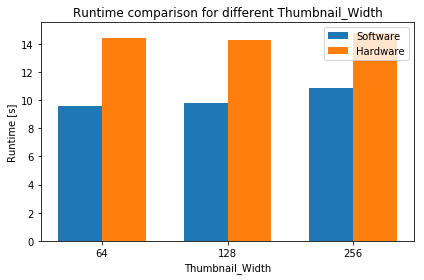

In [10]:
labels = ['64', '128', '256']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, soft_time, width, label='Software')
rects2 = ax.bar(x + width/2, hard_time, width, label='Hardware')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Runtime [s]')
ax.set_xlabel('Thumbnail_Width')
ax.set_title('Runtime comparison for different Thumbnail_Width')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()